In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import wget
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from PIL import Image

In [5]:
path = "../data/oh/"
file_wildfires         = path + "Cleaned_Wildfires.csv"
file_weather           = path + "Cleaned_weather.csv"

In [6]:
Wildfires_df = pd.read_csv(file_wildfires)
Weather_df   = pd.read_csv(file_weather)

In [7]:
Wildfires_df.fillna(0)
Wildfires_df = Wildfires_df.drop(["Unnamed: 0","Unnamed: 0.1" , "Count","Replaced","Year","Month"],axis = 1)
Weather_df = Weather_df.drop(["Unnamed: 0"],axis =1 )

In [8]:
WildfiresWeather_df =  Wildfires_df.merge(Weather_df ,how='left', on = ["Date","Region"])

WildfiresWeather_df = WildfiresWeather_df.set_index(["Date"],drop =True)

In [9]:
def databyRegion(df,reg) :
    target = df[df["Region"] == reg].drop("Region",axis =1)
    return target
    

In [10]:
NSW_df = databyRegion(WildfiresWeather_df,"NSW")

In [11]:
NSW_df

,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,...,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.836935,0.044274,0.0,0.028362,...,14.515009,6.078587,35.878704,27.341182,14.485785,18.562212,7.670482,3.323550,1.354448,0.850048
2005-01-02,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,6.854537,0.173879,0.0,0.271386,...,15.775055,11.737577,33.976604,26.143898,12.067627,22.320857,7.448905,3.030897,0.864556,0.470928
2005-01-03,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,14.969810,3.011912,0.0,10.308246,...,15.362626,6.106235,34.744976,27.408810,16.858456,16.619341,8.515941,3.958409,1.435490,2.002952
2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,22.842566,2.808620,0.0,17.383363,...,7.576938,40.255460,28.945488,23.055527,12.495799,9.455474,7.364222,4.841764,1.401951,1.494301
2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,7.657155,0.157935,0.0,0.273471,...,14.087289,29.763055,29.510120,22.425765,9.611800,13.352380,7.091141,4.014080,1.011328,1.043316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,1.21000,311.100000,16.800000,78.000000,0.000000,0.000000,58.436600,2.124025,0.0,19.255058,...,8.514027,23.311615,22.218430,16.707067,7.288919,8.529138,5.497386,3.043550,1.036175,0.613602
2020-10-28,3.00000,323.166667,20.566667,82.333333,4.509250,20.333333,30.506205,4.350241,0.0,33.377184,...,9.952868,12.846223,22.422768,16.916040,8.654533,7.148141,4.353423,2.551310,0.790777,0.562205
2020-10-29,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,16.275040,2.342508,0.0,12.204651,...,15.170402,9.261971,24.129215,18.045304,9.860389,11.601502,7.925164,3.159553,0.663298,2.072462


In [29]:
# split dataset
def ARPredictbyRegion(reg , lead ) :
    from statsmodels.tsa.ar_model import AutoReg
    def forecast_accuracy(forecast, actual):
        mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
        me = np.mean(forecast - actual)             # ME
        mae = np.mean(np.abs(forecast - actual))    # MAE
        mpe = np.mean((forecast - actual)/actual)   # MPE
        rmse = np.mean((forecast - actual)**2)**.5  # RMSE
        return({'mape':mape, 'me':me, 'mae': mae, 
                'mpe': mpe, 'rmse':rmse})
    df = databyRegion(WildfiresWeather_df,reg)
    X = df["Estimated_fire_area"].values
    train, test = X[1:len(X)-lead], X[len(X)-lead:]
    # train autoregression
    window = 29
    model = AutoReg(train, lags=29)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = forecast_accuracy(predictions,test)
    print('Test RMSE: %.3f' % error['rmse'])
    print('Test MAPE: %.3f' % error['mape'])
    print('Test ME: %.3f' % error['me'])
    print('Test MAE: %.3f' % error['mae'])
    print('Test MPE: %.3f' % error['mpe'])
    print(f'coef: {coef}')
    # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.title(reg + " Estimated Fire Area")
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
<ipython-input-29-fd9924fe5f6c>:5: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
<ipython-input-29-fd9924fe5f6c>:8: RuntimeWarning: divide by zero encountered in true_divide
  mpe = np.mean((forecast - actual)/actual)   # MPE


predicted=3.894572, expected=0.000000
predicted=3.532718, expected=0.000000
predicted=3.686846, expected=0.000000
predicted=3.975580, expected=0.000000
predicted=3.850384, expected=0.000000
predicted=3.491973, expected=0.000000
predicted=3.922298, expected=0.000000
predicted=3.385695, expected=0.000000
predicted=3.361623, expected=0.000000
predicted=3.975142, expected=3.630000
predicted=5.814314, expected=0.000000
predicted=3.802370, expected=0.000000
predicted=3.667780, expected=0.000000
predicted=4.304734, expected=0.000000
predicted=4.001564, expected=0.000000
predicted=2.841559, expected=0.000000
predicted=3.741647, expected=0.000000
predicted=3.493572, expected=0.000000
predicted=3.725492, expected=1.210000
predicted=4.479143, expected=0.000000
predicted=3.694955, expected=0.000000
predicted=3.642457, expected=0.000000
predicted=3.818336, expected=0.000000
predicted=3.747701, expected=2.000000
predicted=4.445023, expected=0.000000
predicted=3.545366, expected=2.000000
predicted=4.

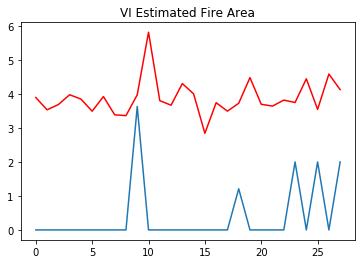

In [30]:
ARPredictbyRegion("VI",28)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
<ipython-input-24-fd9924fe5f6c>:5: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
<ipython-input-24-fd9924fe5f6c>:8: RuntimeWarning: divide by zero encountered in true_divide
  mpe = np.mean((forecast - actual)/actual)   # MPE


predicted=0.935201, expected=3.080000
predicted=2.771519, expected=0.000000
predicted=1.549976, expected=0.000000
predicted=0.978120, expected=0.000000
predicted=1.274450, expected=1.100000
predicted=1.777503, expected=0.000000
predicted=1.531745, expected=0.000000
predicted=1.392551, expected=0.000000
predicted=1.292093, expected=0.000000
predicted=1.073245, expected=0.000000
predicted=1.255891, expected=0.000000
predicted=1.216419, expected=0.000000
predicted=1.263333, expected=0.000000
predicted=1.244187, expected=0.000000
predicted=1.130614, expected=0.000000
predicted=1.177061, expected=0.000000
predicted=1.258215, expected=0.000000
predicted=1.317540, expected=0.000000
predicted=1.158753, expected=0.000000
predicted=1.183811, expected=0.000000
predicted=1.226662, expected=0.000000
predicted=1.285108, expected=0.000000
predicted=1.199380, expected=1.100000
predicted=1.571188, expected=3.300000
predicted=2.620040, expected=0.000000
predicted=1.571041, expected=0.000000
predicted=1.

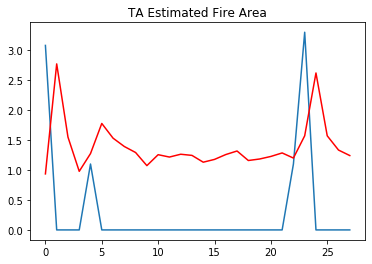

In [26]:
ARPredictbyRegion("TA",28)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
<ipython-input-12-2daa6b175f73>:5: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
<ipython-input-12-2daa6b175f73>:8: RuntimeWarning: divide by zero encountered in true_divide
  mpe = np.mean((forecast - actual)/actual)   # MPE
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


predicted=10.758922, expected=1.320000
predicted=3.690948, expected=1.000000
predicted=2.536629, expected=0.000000
predicted=5.732721, expected=0.000000
predicted=3.490756, expected=1.000000
predicted=3.424098, expected=0.000000
predicted=3.750906, expected=3.100000
predicted=4.204368, expected=2.520000
predicted=5.459080, expected=3.100000
predicted=4.104662, expected=62.602353
predicted=41.037057, expected=5.000000
predicted=1.022617, expected=6.148000
predicted=12.501500, expected=9.821667
predicted=12.195798, expected=1.920000
predicted=8.619387, expected=0.000000
predicted=-3.698568, expected=0.000000
predicted=10.304825, expected=0.000000
predicted=-4.373770, expected=0.000000
predicted=5.526167, expected=0.000000
predicted=2.362821, expected=0.000000
predicted=8.570653, expected=0.000000
predicted=2.392503, expected=0.000000
predicted=4.890120, expected=0.000000
predicted=11.929752, expected=1.320000
predicted=3.525781, expected=0.000000
predicted=1.114866, expected=7.466667
pre

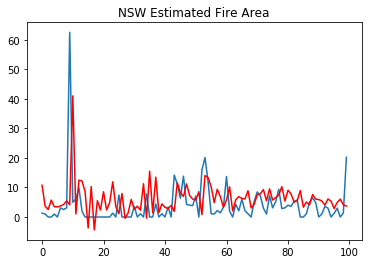

In [23]:
ARPredictbyRegion("NSW",100)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


predicted=88.552744, expected=41.113684
predicted=75.999145, expected=23.605625
predicted=3.914937, expected=17.920000
predicted=61.918465, expected=8.140000
predicted=-1.517439, expected=59.148000
predicted=106.548488, expected=58.025455
predicted=47.012501, expected=53.344828
predicted=75.464680, expected=60.988421
predicted=72.151709, expected=49.777368
predicted=32.363737, expected=26.177778
predicted=57.145461, expected=55.495385
predicted=36.690080, expected=19.886667
predicted=52.956232, expected=17.272727
predicted=26.974506, expected=1.680000
predicted=39.186036, expected=49.966364
predicted=62.914399, expected=53.305556
predicted=46.360479, expected=153.506341
predicted=123.301720, expected=95.285714
predicted=87.410901, expected=80.083571
predicted=99.243876, expected=12.859091
predicted=36.275303, expected=41.970476
predicted=44.432371, expected=14.509091
predicted=34.527031, expected=12.286667
predicted=39.686368, expected=12.750000
predicted=30.452198, expected=144.990566

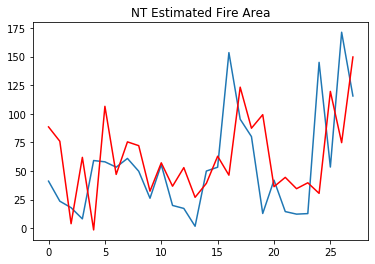

In [16]:
ARPredictbyRegion("NT",28)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


predicted=56.083384, expected=5.720000
predicted=29.360071, expected=25.371429
predicted=43.618299, expected=16.996364
predicted=31.759000, expected=69.250000
predicted=71.518034, expected=90.922703
predicted=81.372626, expected=122.912000
predicted=116.500674, expected=84.618947
predicted=80.032686, expected=25.544118
predicted=54.564611, expected=51.480000
predicted=60.465133, expected=47.122581
predicted=69.762689, expected=63.245000
predicted=74.806449, expected=55.899643
predicted=68.363198, expected=39.300000
predicted=52.851033, expected=49.680000
predicted=59.003495, expected=140.009800
predicted=126.732657, expected=156.740000
predicted=140.738899, expected=114.597826
predicted=118.764843, expected=40.913056
predicted=59.833747, expected=7.560000
predicted=34.078216, expected=15.573333
predicted=44.013101, expected=100.242500
predicted=104.662433, expected=99.338400
predicted=109.373094, expected=89.475641
predicted=94.557216, expected=32.970000
predicted=54.523762, expected=2

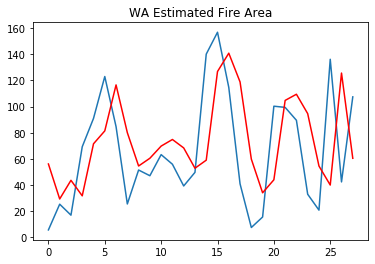

In [17]:
ARPredictbyRegion("WA",28)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


predicted=114.764076, expected=96.262933
predicted=64.547726, expected=33.945000
predicted=68.151925, expected=172.383509
predicted=139.750047, expected=136.468958
predicted=144.011912, expected=282.253575
predicted=231.562979, expected=407.715642
predicted=324.356049, expected=336.708284
predicted=303.420381, expected=147.983571
predicted=140.749847, expected=130.214250
predicted=162.695044, expected=248.450662
predicted=212.949030, expected=59.546250
predicted=119.512742, expected=174.928279
predicted=124.642408, expected=136.950000
predicted=153.459011, expected=187.569130
predicted=154.439984, expected=146.253556
predicted=147.698264, expected=146.303014
predicted=165.108999, expected=234.162824
predicted=202.690697, expected=252.575385
predicted=264.208785, expected=299.938413
predicted=215.228297, expected=88.605405
predicted=159.052052, expected=89.569375
predicted=114.744684, expected=38.124000
predicted=96.828748, expected=52.332000
predicted=61.367393, expected=78.670769
pred

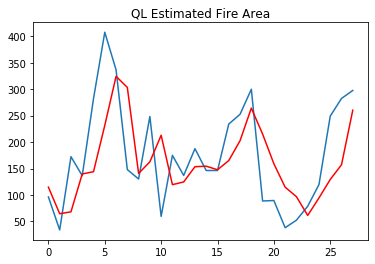

In [18]:
ARPredictbyRegion("QL",28)